In [1]:
import time

import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable

import stg_energy.fig3_amortize_energy.viz as viz
from pyloric import create_prior, get_time, simulate_energyscape, stats
from sbi.utils.regression_net.get_nn_classifier import classifier
from sbi.utils.regression_net.train_classifier import fit_regression_net
from stg_energy.common import col, get_labels_8pt, svg
from stg_energy.fig3_amortize_energy.helper_functions import (
    active_subspace,
    get_gradient,
)

# Figure 3: additional nets
Here, we train 3 nets to predict the energy in AB/PD, LP, and PY. This will be used in fig5_cc

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
PANEL_A = "../svg/panel_a.svg"
PANEL_B = "../svg/panel_b.svg"
PANEL_C = "../svg/panel_c.svg"

### Load experimental data

In [4]:
prior_11 = create_prior(log=True)
dimensions_11 = 31
lims_11 = np.asarray(
    [-np.sqrt(3) * np.ones(dimensions_11), np.sqrt(3) * np.ones(dimensions_11)]
).T

params_mean_11 = prior_11.mean.numpy()
params_std_11 = prior_11.stddev.numpy()

In [5]:
data = np.load("../../results/11deg_post_pred/11_deg_post_pred_close_to_obs.npz")
good_stats = data["sample_stats"]
good_params = data["sample_params"]
good_seeds = data["sample_seeds"]

In [6]:
sample_params = good_params
sample_stats = good_stats
print("There are", len(good_seeds), "datapoints in this dataset")

There are 55043 datapoints in this dataset


In [7]:
sample_stats = data["sample_stats"]
sample_params = data["sample_params"]
sample_seeds = data["sample_seeds"]

In [8]:
energies = sample_stats[:, 21:24]
summed_energies = np.sum(energies, axis=1)

# Panel 0: Fit regression net

In [9]:
energies = torch.as_tensor(energies)
sample_stats = torch.as_tensor(sample_stats)

In [10]:
print(energies.shape)

torch.Size([55043, 3])


In [11]:
num_test = 500

test_params = good_params[:num_test]
train_params = good_params[num_test:]
mean_params = np.mean(train_params, axis=0)
std_params = np.std(train_params, axis=0)

train_params_norm = (train_params - mean_params) / std_params
test_params_norm = (test_params - mean_params) / std_params

### AB/PD

In [43]:
train_energy_ABPD = energies[num_test:, 0].unsqueeze(1)
test_energy_ABPD = energies[:num_test, 0].unsqueeze(1)
mean_energy = torch.mean(train_energy_ABPD)
std_energy = torch.std(train_energy_ABPD)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

In [44]:
nn = classifier(dim=31)

In [45]:
converged_nn = fit_regression_net(
    nn,
    train_params_norm,
    train_energy_ABPD_norm,
    num_train=train_params_norm.shape[0],
    batch_size=50,
    stop_after_epochs=10,
    max_epochs=200,
)
np.savez('../../results/regression_nets/201007_predict_total_energy_ABPD.npz', converged_nn=converged_nn, mean_params=mean_params, std_params=std_params, mean_energy=mean_energy, std_energy=std_energy)

Total number of trainable parameters 169001
Training loss   0.0024701463387346544
validation loss 0.0008987268660043381
Training loss   0.0010592765318238294
validation loss 0.0006617953384501687
Training loss   0.0007933264820722042
validation loss 0.0005149087516077061
Training loss   0.0006942612797589827
validation loss 0.0004975700392417685
Training loss   0.0006159773559788863
validation loss 0.0004282528297219333
Training loss   0.0005756694181246083
validation loss 0.0004232845531211437
Training loss   0.0005449943847858956
validation loss 0.0003854897482735536
Training loss   0.0005143139853572954
validation loss 0.0003544431934380728
Training loss   0.0004950413541720192
validation loss 0.0003858382819607977
Training loss   0.00048543369500959145
validation loss 0.00035472796115030615
Training loss   0.0004678096998187882
validation loss 0.0003369252367319042
Training loss   0.0004572099554118721
validation loss 0.0003338536469557764
Training loss   0.0004440778439718504
vali

In [46]:
data = np.load(
    "../../results/regression_nets/201007_predict_total_energy_ABPD.npz",
    allow_pickle=True,
)
converged_nn = data["converged_nn"].tolist()

In [47]:
predictions = converged_nn.predict(torch.as_tensor(test_params_norm)).detach()

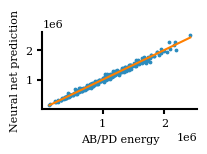

In [48]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = test_energy_ABPD_norm[:300] * std_energy + mean_energy
    unnorm_y = predictions[:300] * std_energy + mean_energy
    ax.scatter(x=unnorm_x.numpy(), y=unnorm_y.numpy(), s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x.numpy()), np.max(unnorm_x.numpy()), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("AB/PD energy")
    ax.set_ylabel("Neural net prediction")

### LP

In [20]:
nn = classifier(dim=31)

In [21]:
train_energy_ABPD = energies[num_test:, 1].unsqueeze(1)
test_energy_ABPD = energies[:num_test, 1].unsqueeze(1)
mean_energy = torch.mean(train_energy_ABPD)
std_energy = torch.std(train_energy_ABPD)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

In [22]:
converged_nn = fit_regression_net(
    nn,
    train_params_norm,
    train_energy_ABPD_norm,
    num_train=train_params_norm.shape[0],
    batch_size=50,
    stop_after_epochs=10,
    max_epochs=200,
)
np.savez('../../results/regression_nets/201007_predict_total_energy_LP.npz', converged_nn=converged_nn, mean_params=mean_params, std_params=std_params, mean_energy=mean_energy, std_energy=std_energy)

Total number of trainable parameters 169001
Training loss   0.002840474718298904
validation loss 0.0010780653673011596
Training loss   0.0013582053965165838
validation loss 0.0008714694355628995
Training loss   0.0010942079029240277
validation loss 0.0007588154464741566
Training loss   0.0009586672672975779
validation loss 0.0007090356883846435
Training loss   0.0008818506120105797
validation loss 0.0007478458122252107
Training loss   0.0008168353670613047
validation loss 0.0005806248174087374
Training loss   0.0007673200060348749
validation loss 0.0005449614094059802
Training loss   0.0007335096174205084
validation loss 0.000479466601093082
Training loss   0.000715538401655565
validation loss 0.0005298171168505654
Training loss   0.0006803428588997854
validation loss 0.0004727425926137036
Training loss   0.0006647786110210945
validation loss 0.00045062472051868297
Training loss   0.0006433414218325297
validation loss 0.0004192566615209243
Training loss   0.0006281730164420115
validati

In [23]:
data = np.load(
    "../../results/regression_nets/201007_predict_total_energy_LP.npz",
    allow_pickle=True,
)
converged_nn = data["converged_nn"].tolist()

In [24]:
predictions = converged_nn.predict(torch.as_tensor(test_params_norm)).detach()

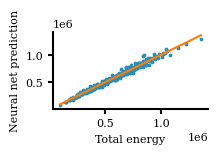

In [25]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = test_energy_ABPD_norm[:300] * std_energy + mean_energy
    unnorm_y = predictions[:300] * std_energy + mean_energy
    ax.scatter(x=unnorm_x.numpy(), y=unnorm_y.numpy(), s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x.numpy()), np.max(unnorm_x.numpy()), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Total energy")
    ax.set_ylabel("Neural net prediction")

# PY

In [67]:
nn = classifier(dim=31)

In [68]:
train_energy_ABPD = energies[num_test:, 2].unsqueeze(1)
test_energy_ABPD = energies[:num_test, 2].unsqueeze(1)
mean_energy = torch.mean(train_energy_ABPD)
std_energy = torch.std(train_energy_ABPD)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

In [69]:
converged_nn = fit_regression_net(
    nn,
    train_params_norm,
    train_energy_ABPD_norm,
    num_train=train_params_norm.shape[0],
    batch_size=50,
    stop_after_epochs=10,
    max_epochs=200,
)
np.savez('../../results/regression_nets/201007_predict_total_energy_PY.npz', converged_nn=converged_nn, mean_params=mean_params, std_params=std_params, mean_energy=mean_energy, std_energy=std_energy)

Total number of trainable parameters 169001
Training loss   0.002117187371563999
validation loss 0.0005942763086309354
Training loss   0.0007571277575251055
validation loss 0.0004812629046610033
Training loss   0.0006085111304224836
validation loss 0.0004248581929123806
Training loss   0.0005537201065897657
validation loss 0.0004099898327118098
Training loss   0.0005094241718007276
validation loss 0.0004028098995769166
Training loss   0.0004910056251908666
validation loss 0.00038374950537350505
Training loss   0.00046914442897470114
validation loss 0.0003536218364136575
Training loss   0.0004457534448549666
validation loss 0.00036513699725693676
Training loss   0.00043523076593021665
validation loss 0.00035096922638381325
Training loss   0.00041619982006774447
validation loss 0.0003371635916293705
Training loss   0.00040951495144134957
validation loss 0.0003254632918824852
Training loss   0.00039977927503951325
validation loss 0.0003487401156183452
Training loss   0.0003918529629263835

In [70]:
data = np.load(
    "../../results/regression_nets/201007_predict_total_energy_PY.npz",
    allow_pickle=True,
)
converged_nn = data["converged_nn"].tolist()

In [71]:
predictions = converged_nn.predict(torch.as_tensor(test_params_norm)).detach()

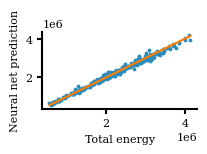

In [72]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = test_energy_ABPD_norm[:300] * std_energy + mean_energy
    unnorm_y = predictions[:300] * std_energy + mean_energy
    ax.scatter(x=unnorm_x.numpy(), y=unnorm_y.numpy(), s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x.numpy()), np.max(unnorm_x.numpy()), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Total energy")
    ax.set_ylabel("Neural net prediction")